In [1]:
# Sample connection
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Cleaning connection")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/08/21 22:58:27 WARN Utils: Your hostname, DESKTOP-L9KIK4G resolves to a loopback address: 127.0.1.1; using 172.23.126.166 instead (on interface eth0)
22/08/21 22:58:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/21 22:58:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Linear Regression

In [2]:
from statsmodels.formula.api import ols, glm
# VectorAssembler creates new vectors from existing columns
from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.linalg import Vectors

from pyspark.ml.regression import LinearRegression

import pandas as pd

In [3]:
sdf = spark.read.parquet('../data/curated/final2/clean_dataset.parquet/').drop('pickup_datetime', 'DOLocationID').dropDuplicates()
sdf.printSchema()

root
 |-- PULocationID: long (nullable = true)
 |-- PUWeekday: integer (nullable = true)
 |-- PUHour: integer (nullable = true)
 |-- PUMonth: integer (nullable = true)
 |-- PUDay: integer (nullable = true)
 |-- count: long (nullable = true)
 |-- wnd: double (nullable = true)
 |-- vis: double (nullable = true)
 |-- tmp: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- atm: double (nullable = true)
 |-- cc: double (nullable = true)



## Total trash

In [91]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=sampled_model_sdf.columns, outputCol=vector_col)
df_vector = assembler.transform(sampled_model_sdf).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

matrix.collect()[0]["pearson({})".format(vector_col)].values

22/08/21 18:16:15 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


array([ 1.        ,  0.10138565, -0.00554797, ..., -0.00501742,
       -0.00789543,  1.        ])

In [93]:
matrix.collect()

[Row(pearson(corr_features)=DenseMatrix(549, 549, [1.0, 0.1014, -0.0055, 0.0186, -0.0066, -0.0015, -0.0065, -0.0043, ..., -0.0058, -0.0041, -0.0009, -0.0007, -0.0007, -0.005, -0.0079, 1.0], False))]

# Statsmodel.sm. midagi ols

In [20]:
from statsmodels.formula.api import ols, glm

In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [22]:
from pyspark.sql.types import DoubleType
dummy = sdf.select('count', 'wnd', 'vis', 'tmp', 'dew', 'atm', 'cc', 'PUMonth', 'PUWeekday','PUDay', 'PUHour', 'PULocationID')\
    .dropna('any')\
    .withColumn('count', F.col('count').cast(DoubleType()))
dummy.printSchema()


root
 |-- count: double (nullable = true)
 |-- wnd: double (nullable = true)
 |-- vis: double (nullable = true)
 |-- tmp: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- atm: double (nullable = true)
 |-- cc: double (nullable = true)
 |-- PUMonth: integer (nullable = true)
 |-- PUWeekday: integer (nullable = true)
 |-- PUDay: integer (nullable = true)
 |-- PUHour: integer (nullable = true)
 |-- PULocationID: long (nullable = true)



In [25]:
fit = smf.ols(
    formula="count ~ wnd + tmp + dew + atm + cc + PUMonth + PUWeekday + PUDay + PUHour + PULocationID",
    #formula="count ~ wnd + vis + tmp + dew + atm + cc + PUMonth + PUWeekday + PUDay + PUHour + PULocationID",
    data=dummy.sample(withReplacement=False, fraction=0.05, seed=42).toPandas()
).fit()

In [24]:
fit.summary()
# 0.320

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     213.2
Date:                Sun, 21 Aug 2022   Prob (F-statistic):               0.00
Time:                        23:08:03   Log-Likelihood:            -3.3138e+05
No. Observations:               52707   AIC:                         6.628e+05
Df Residuals:                   52695   BIC:                         6.629e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      106.1447    129.538      0.819      0.413    -147.750     360.040
wnd              0.1346      0.032      4.207      0.000       0.072       0.197
vis              0.0001      0.000      0.532      0.595      -0.000       0.001
tmp             -0.0722      0.017     -4.178      0.000      -0.106      -0.038
dew              0.0642      0.017      3.813      0.000       0.031       0.097
atm             -0.0080      0.013     -0.624      0.532      -0.033       0.017
cc              -0.3453      0.275     -1.258      0.209      -0.884       0.193
PUMonth         -4.0175      0.802     -5.010      0.000      -5.589      -2.446
PUWeekday        0.8568      0.283      3.023      0.003       0.301       1.412
PUDay            0.0761      0.065      1.172      0.241      -0.051       0.203
PUHour           3.0368      0.095     31.919      0.000       2.850       3.223
PULocationID     0.2454      0.007     32.730      0.000       0.231       0.260
==============================================================================
Omnibus:                    31055.589   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           287770.212
Skew:                           2.762   Prob(JB):                         0.00
Kurtosis:                      13.027   Cond. No.                     4.25e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Correllation matrix

In [4]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
columns = ['PUWeekday', 'PUHour', 'PUMonth', 'PUDay', 'wnd', 'vis', 'tmp', 'dew', 'atm', 'cc']
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=columns, outputCol=vector_col)
df_vector = assembler.transform(sdf).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

22/08/21 22:59:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/08/21 22:59:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [5]:
matrix.collect()[0][0].toArray().tolist()

[[1.0,
  0.010498503549288414,
  0.003823848267355205,
  0.011324057998288917,
  0.0036050303130158675,
  -0.0019407536750495494,
  0.0034407500503514776,
  0.02468323403730092,
  -0.05015143781851093,
  0.034813648521991605],
 [0.010498503549288414,
  1.0,
  -0.0019426049850655015,
  -0.0014382127045732775,
  0.2573273114829882,
  0.02366160385430587,
  0.2909592231521646,
  -0.09156335820332923,
  -0.015145703177550386,
  -0.02200981004927506],
 [0.003823848267355205,
  -0.0019426049850655015,
  1.0,
  0.020561574290398114,
  -0.07199032207812657,
  0.13027957261562295,
  0.25976273672423333,
  0.3689848518749176,
  0.21018989912764008,
  -0.052626145127812815],
 [0.011324057998288917,
  -0.0014382127045732775,
  0.020561574290398114,
  1.0,
  0.07303572704720857,
  0.03677773760034275,
  0.07952479117767565,
  0.055877242622921194,
  0.06400347790946961,
  -0.008514753825332736],
 [0.0036050303130158675,
  0.2573273114829882,
  -0.07199032207812657,
  0.07303572704720857,
  1.0,
  0

<AxesSubplot:>

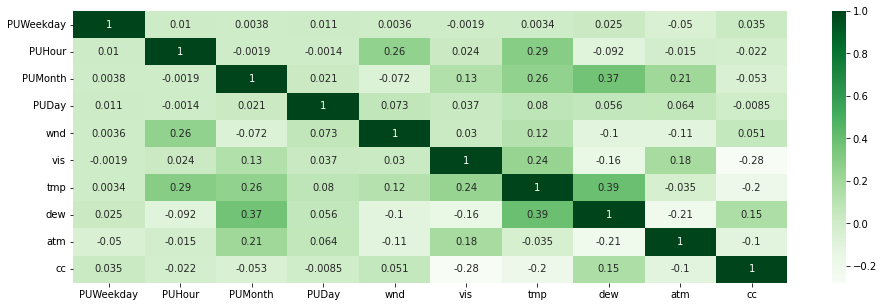

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = matrix.collect()[0][0].toArray().tolist()

corr_matrix_df = pd.DataFrame(
    data=corr_matrix,
    columns=columns,
    index=columns
)

plt.figure(figsize=(16, 5))
sns.heatmap(corr_matrix_df,
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)


## Statsmodel by pyspark

In [7]:
# VectorAssembler creates new vectors from existing columns
from pyspark.ml.feature import VectorAssembler

onehotdata = OneHotEncoder(
    inputCol='PULocationID',
    outputCol='location_vec'
).fit(sdf).transform(sdf)


assembler = VectorAssembler(
    inputCols=['wnd', 'vis', 'tmp', 'dew', 'atm', 'cc', 'PUMonth', 'PUWeekday', 'PUDay', 'PUHour', 'location_vec'],
    outputCol='features')
model_sdf = assembler.transform(onehotdata)
model_sdf.select('features').show(10, truncate=False)

# features = 'features'
# input_cols = ['wnd', 'vis', 'tmp', 'dew', 'atm', 'cc',
#               'PUMonth', 'PUWeekday', 'PUDay', 'PUHour', 'location_vec']
# assembler = VectorAssembler(
#     # which column to combine
#     inputCols=input_cols,
#     # How should the combined columns be named
#     outputCol=features
# )

# model_sdf = assembler.transform(ohe_sdf)
# # # Display the features and targets for our model
# print(model_sdf.select('features').head(2))#, model_sdf.select('count').head(5)


+--------------------------------------------------------------------------------------------+
|features                                                                                    |
+--------------------------------------------------------------------------------------------+
|(273,[0,1,2,3,4,5,6,7,8,9,162],[21.0,16093.0,178.0,150.0,10139.0,2.0,6.0,5.0,1.0,12.0,1.0]) |
|(273,[0,1,2,3,4,6,7,8,9,242],[41.0,16093.0,183.0,89.0,10143.0,6.0,6.0,2.0,6.0,1.0])         |
|(273,[0,1,2,3,4,6,7,8,184],[67.0,16093.0,217.0,44.0,10126.0,6.0,7.0,3.0,1.0])               |
|(273,[0,1,2,3,4,5,6,7,8,9,152],[26.0,16093.0,167.0,56.0,10145.0,4.0,6.0,7.0,3.0,8.0,1.0])   |
|(273,[0,1,2,3,4,5,6,7,8,9,231],[31.0,16093.0,189.0,61.0,10158.0,2.0,6.0,1.0,4.0,5.0,1.0])   |
|(273,[0,1,2,3,4,5,6,7,8,9,136],[41.0,16093.0,183.0,83.0,10152.0,2.0,6.0,1.0,4.0,18.0,1.0])  |
|(273,[0,1,2,3,4,5,6,7,8,9,78],[15.0,16093.0,211.0,106.0,10126.0,2.0,6.0,7.0,10.0,8.0,1.0])  |
|(273,[0,1,2,3,4,5,6,7,8,9,245],[57.0,16093.0,267.

In [ ]:
#df2 = model_sdf.dropDuplicates()

In [8]:
from pyspark.ml.regression import LinearRegression

lm = LinearRegression(
    featuresCol='features', 
    labelCol='count'
).fit(model_sdf)

22/08/21 23:01:24 WARN Instrumentation: [a8c396e4] regParam is zero, which might cause numerical instability and overfitting.


22/08/21 23:01:27 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/08/21 23:01:27 WARN Instrumentation: [a8c396e4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [9]:
lm.summary.r2

0.6738160750022345

In [10]:
lm.summary.pValues

Py4JJavaError: An error occurred while calling o190.pValues.
: java.lang.UnsupportedOperationException: No p-value available for this LinearRegressionModel
	at org.apache.spark.ml.regression.LinearRegressionSummary.pValues$lzycompute(LinearRegression.scala:1072)
	at org.apache.spark.ml.regression.LinearRegressionSummary.pValues(LinearRegression.scala:1069)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)


In [11]:
print("Coefficients: " + str(lm.coefficients))
print("Intercept: " + str(lm.intercept))

Coefficients: [-0.020637855851481344,0.0003034354553534569,-0.10112948931525566,0.0693453193126724,0.006726904826221642,-0.1366875589287444,-5.959135384309572,1.4257981553085646,0.0052483635120060225,3.7971846887729286,0.0,-186.0528807377623,-187.50222264658555,-185.05855447389894,-161.03290640578285,-183.1667230529777,-181.52756020876703,-121.06327494501494,-188.71364653976488,-190.97994371852016,-182.25577782570852,-185.09531832678456,-180.38978278409482,-79.53333610412682,-183.48627828067976,-185.9833535208714,-185.42905237498908,-172.76986466236718,-185.583926930552,-185.65976968683523,-186.55023156086267,-184.892448611296,-183.39077307596037,-185.30594557681795,-149.50987369024935,-151.06390107801042,-185.82440479507872,-192.53554882288702,-183.2103937738213,-186.29837590747036,-188.3928371422759,-190.94187178848475,-184.57371558305573,-147.31835845893707,-193.48322521471403,-183.2819657182721,-175.90914898200043,-177.3288624737144,-181.84045799326097,-183.09277866191675,-171.8855

In [12]:
lm.summary.r2#.summary.pValues

0.6738160750022345

In [13]:
trainingSummary = lm.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 18
objectiveHistory: [0.5000000000000001, 0.18554629808357248, 0.16609465666001366, 0.1656290639070488, 0.16541580926090882, 0.16526109880741535, 0.16519444271045447, 0.1651387925298528, 0.16458301866486608, 0.1640258833286939, 0.16362203413334298, 0.16315703219334926, 0.16309719372375597, 0.1630919665687085, 0.1630919627583831, 0.1630919625395053, 0.1630919624997128, 0.16309196249892777, 0.1630919624988823]


+-------------------+
|          residuals|
+-------------------+
|-6.5538200005479155|
| 3.0352928867120426|
|  43.04191186260306|
|  -39.7496486680277|
| 27.446033287152517|
| -23.03631618815072|
|  -71.9158846177331|
|  35.64459066348283|
|  6.835503993476124|
|  9.675370459458875|
|-14.033113931787923|
| 51.637155700582426|
|-24.762485330210566|
|-28.582318130649455|
|  -278.341656877835|
|  6.260449099064431|
|  78.89309319804966|
|-5.4471056092597365|
|-22.188966110605023|
|  31.13305648135892|
+-------------------+
only showing top 20 rows

RMSE: 75.448525
r2: 0.673816


In [14]:
from pyspark.ml.regression import GeneralizedLinearRegression

glm = GeneralizedLinearRegression(
    featuresCol='features',
    labelCol='count'
).fit(model_sdf)

22/08/21 23:03:08 WARN Instrumentation: [7d8b2004] regParam is zero, which might cause numerical instability and overfitting.


22/08/21 23:03:11 WARN Instrumentation: [7d8b2004] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [19]:
summary = glm.summary
# ei print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
# ei print("T Values: " + str(summary.tValues))
# ei print("P Values: " + str(summary.pValues))

print("Dispersion: " + str(summary.dispersion)) # töötas
print("Null Deviance: " + str(summary.nullDeviance)) # töötas
print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull)) # töödas
print("Deviance: " + str(summary.deviance)) # töödas
print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom)) # töödas
print("AIC: " + str(summary.aic)) #täädas
print("Deviance Residuals: ") 
summary.residuals().show() #täädas

Dispersion: 5693.956600470586
Null Deviance: 18438505669.752544
Residual Degree Of Freedom Null: 1056541
Deviance: 6014344150.465864
Residual Degree Of Freedom: 1056268
AIC: 12134700.679032985
Deviance Residuals: 


+-------------------+
|  devianceResiduals|
+-------------------+
|-6.5538200005479155|
| 3.0352928867120426|
|  43.04191186260306|
|  -39.7496486680277|
| 27.446033287152517|
| -23.03631618815072|
|  -71.9158846177331|
|  35.64459066348283|
|  6.835503993476124|
|  9.675370459458875|
|-14.033113931787923|
| 51.637155700582426|
|-24.762485330210566|
|-28.582318130649455|
|  -278.341656877835|
|  6.260449099064431|
|  78.89309319804966|
|-5.4471056092597365|
|-22.188966110605023|
|  31.13305648135892|
+-------------------+
only showing top 20 rows



In [110]:
model_sdf.count()

73788068

In [111]:
df2 = model_sdf.dropDuplicates()
df2.count()

19911164

In [81]:
help(glm)

Help on GeneralizedLinearRegressionModel in module pyspark.ml.regression object:

class GeneralizedLinearRegressionModel(_JavaRegressionModel, _GeneralizedLinearRegressionParams, pyspark.ml.util.JavaMLWritable, pyspark.ml.util.JavaMLReadable, pyspark.ml.util.HasTrainingSummary)
 |  GeneralizedLinearRegressionModel(*args, **kwds)
 |  
 |  Model fitted by :class:`GeneralizedLinearRegression`.
 |  
 |  .. versionadded:: 2.0.0
 |  
 |  Method resolution order:
 |      GeneralizedLinearRegressionModel
 |      _JavaRegressionModel
 |      RegressionModel
 |      pyspark.ml.wrapper.JavaPredictionModel
 |      pyspark.ml.base.PredictionModel
 |      pyspark.ml.wrapper.JavaModel
 |      pyspark.ml.wrapper.JavaTransformer
 |      pyspark.ml.wrapper.JavaParams
 |      pyspark.ml.wrapper.JavaWrapper
 |      pyspark.ml.base.Model
 |      pyspark.ml.base.Transformer
 |      _GeneralizedLinearRegressionParams
 |      pyspark.ml.base._PredictorParams
 |      pyspark.ml.param.shared.HasLabelCol
 |     

In [ ]:
features = 'features'
input_cols = ['PUMonth', 'PUWeekday', 'PUDay',
              'PUHour', 'wnd', 'vis', 'tmp', 'dew', 'atm', 'cc', 'PULocationID_vec']

# onehotencoder to qualificationIndex
onehotencoder = OneHotEncoder(
    inputCol="PULocationID",
    outputCol="PULocationID_vec"
)

assembler = VectorAssembler(
    # which column to combine
    inputCols=input_cols,
    # How should the combined columns be named
    outputCol=features
)

# model_sdf = assembler.transform(sdf.dropna('any'))
# model_sdf = onehotencoder.tran
# # Display the features and targets for our model
# model_sdf.select('features').head(5), model_sdf.select('count').head(5)
model_sdf = assembler.transform(onehotencoder.fit(sdf).transform(sdf))
#model_sdf.select('features').head(5)
